# 라이브러리

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,233 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155225 files and d

In [2]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x
!pip install wordcloud
!pip install squarify
!pip install pyLDAvis==2.1.2
!pip install pmdarima

+ pip install konlpy
     |████████████████████████████████| 19.4 MB 6.5 MB/s 
     |████████████████████████████████| 448 kB 54.5 MB/s 
+ bash -x
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
/etc/os-release:NAME="Ubuntu"
/etc/os-release:ID=ubuntu
/etc/os-release:ID_LIKE=debian
/etc/os-release:PRETTY_NAME="Ubuntu 18.04.5 LTS"
/etc/os-release:HOME_URL="https://www.ubuntu.com/"
/

In [3]:
import numpy as np
import pandas as pd

# 시각화
%matplotlib inline  
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 12, 12   # 그래프 크기
from matplotlib import font_manager
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지
plt.rc('font', family='NanumBarunGothic') 

import seaborn as sns
from wordcloud import WordCloud
# import squarify
from collections import Counter

# 경고문 무시
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk import word_tokenize, bigrams, ConditionalFreqDist
from konlpy.tag import Okt, Hannanum, Kkma, Komoran, Mecab
from gensim import corpora

from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib

# 파일 합치기
import glob
import sys
import os

# 기타
import re
import requests
import json
import time
from google.colab import drive

# 데이터 로드

In [ ]:
# 개별 언론사 통합

# # 파일 경로
# drive.mount('/content/drive')
# many_file_path = r"/content/drive/MyDrive/3조_final_project/01_뉴스 키워드/뉴스 기사_mecab/*.csv"


# # 파일 경로를 리스트로
# file_path_list = glob.glob(many_file_path)
# # print('파일 수:', len(file_path_list))   # 13
# # file_path_list


# # 언론사 전체 파일 합치기
# data_tot = pd.DataFrame()
# for i in range(0, len(file_path_list)):
#     data_tot = pd.concat([data_tot, pd.read_csv(file_path_list[i])])
# # print(data_tot.shape)   # (897571, 6)
# # data_tot


# # 데이터 확인
# # data_tot.info()
# # data_tot.isna().sum()


# # 데이터 전처리
# data_tot = data_tot[data_tot['제목'] != '제목']   # Null값 삭제
# data_tot.drop(['Unnamed: 0'], axis=1, inplace=True)   # 사용하지 않는 컬럼 삭제
# data_tot.sort_values(by=['일자','언론사','기고자'], inplace=True)   # 정렬
# data_tot.reset_index(drop=True, inplace=True)   # 인덱스 초기화
# # data_tot


# # 파일 저장
# # data_tot.to_csv('뉴스기사_all.csv', index=False, encoding='utf-8-sig')

In [ ]:
# data_tot 파일 불러오기
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/3조_final_project/01_뉴스 기사/뉴스기사_all.csv'
data_tot = pd.read_csv(file_path)
print('data_tot.shape : ', data_tot.shape)
data_tot.head(10)

# 전처리

## corpus (말뭉치)

In [ ]:
type(data_tot['mecab_nouns'][0])   # str

In [ ]:
def word_list(d) :
  # 개별 단어로 분리
  d = d.replace('[','')
  d = d.replace(']','')
  d = d.replace(" ","")
  d = d.replace("'","")

  # 개별 단어를 리스트로
  d = d.split(',')

  return d

In [ ]:
corpus = ','.join(data_tot['mecab_nouns'])
corpus = word_list(corpus)

print(len(corpus))
corpus[:10]

## StopWords (불용어)
- https://www.ranks.nl/stopwords/korean
- word_freq_1.csv
- pyLDAvis (topic = 35)

In [ ]:
# 파일 불러오기
stop_words = pd.read_csv(r'/content/drive/MyDrive/3조_final_project/01_뉴스 기사/stop_words.txt', sep='\n', encoding='utf8', header=None)

# set으로 중복 제거 후 리스트로 변환
stop_words = list(set(stop_words[0]))

In [ ]:
corpus = [x for x in corpus if x not in stop_words]

print(len(corpus))
corpus[:10]

## 전처리된 컬럼 추가

In [ ]:
data_tot['noun'] = data_tot['mecab_nouns'].apply(word_list)
data_tot['noun'] = data_tot['noun'].apply(lambda x : [word for word in x if word not in stop_words])
data_tot.head(3)

# 바이그램

In [ ]:
bgram = bigrams(corpus)   # <generator object bigrams at 0x7f334a7d3bd0>
bgram_list = [x for x in bgram]

print(len(bgram_list))
print(bgram_list[:1000])

5751908
[('미세먼지', '문'), ('문', '대통령'), ('대통령', '일자리'), ('일자리', '수석'), ('수석', '차관'), ('차관', '인사'), ('인사', '발표'), ('발표', '미세먼지'), ('미세먼지', '농도'), ('농도', '뚝'), ('뚝', '전국'), ('전국', '중부'), ('중부', '황사'), ('황사', '미세먼지'), ('미세먼지', '전국'), ('전국', '대부분'), ('대부분', '중부'), ('중부', '황사'), ('황사', '미세먼지'), ('미세먼지', '부산대'), ('부산대', '서울대'), ('서울대', '인권'), ('인권', '센터'), ('센터', '인권'), ('인권', '평등'), ('평등', '대학'), ('대학', '협약'), ('협약', '부산시'), ('부산시', '국제'), ('국제', '평화'), ('평화', '도시'), ('도시', '가입'), ('가입', '국내'), ('국내', '임금'), ('임금', '체불'), ('체불', '불만'), ('불만', '공장'), ('공장', '불'), ('불', '조사'), ('조사', '대구'), ('대구', '예수'), ('예수', '중심'), ('중심', '교회'), ('교회', '관련'), ('관련', '확진'), ('확진', '누적'), ('누적', '충북'), ('충북', '주택'), ('주택', '인허가'), ('인허가', '가구'), ('가구', '제주시'), ('제주시', '대기'), ('대기', '오염'), ('오염', '물질'), ('물질', '배출'), ('배출', '사업장'), ('사업장', '특별'), ('특별', '점검'), ('점검', '제주'), ('제주', '광공업'), ('광공업', '생산'), ('생산', '증가세'), ('증가세', '판매액'), ('판매액', '지수'), ('지수', '증가'), ('증가', '대법원'), ('대법원', '고유'), ('고유', '사건'), ('사건'

## 어휘 동시 출현 빈도의 계수화

In [ ]:
bgrams = [bigrams(x) for x in data_tot['noun'].tolist()]
token = []

for idx, i in enumerate(bgrams) :
  try : 
    token += ([x for x in i])
  except :
    print(f'{idx} : {list(i)}')
token

386 : []
387 : []
773 : []
2307 : []
2308 : []
4359 : []
5149 : []
5467 : []
5468 : []
8672 : []
8673 : []
10882 : []
11997 : []
11998 : []
12580 : []
15104 : []
15105 : []
15348 : []
16246 : []
16618 : []
17045 : []
17187 : []
17188 : []
18257 : []
18258 : []
18456 : []
19607 : []
20370 : []
20371 : []
20487 : []
21710 : []
21857 : []
22515 : []
23673 : []
23674 : []
24241 : []
25688 : []
25961 : []
26706 : []
27006 : []
27007 : []
28637 : []
29743 : []
29854 : []
30390 : []
30391 : []
31841 : []
32526 : []
33105 : []
33561 : []
33562 : []
35739 : []
35740 : []
35748 : []
35783 : []
36242 : []
36807 : []
36808 : []
38748 : []
38749 : []
40068 : []
41559 : []
41919 : []
41920 : []
42423 : []
45225 : []
45226 : []
47381 : []
47502 : []
47508 : []
48463 : []
48658 : []
48659 : []
49059 : []
49246 : []
51512 : []
51517 : []
51976 : []
51977 : []
53612 : []
54170 : []
54171 : []
55162 : []
55163 : []
57104 : []
57105 : []
57119 : []
57124 : []
58332 : []
59464 : []
60315 : []
60316 : []
63

[('문', '대통령'),
 ('대통령', '일자리'),
 ('일자리', '수석'),
 ('수석', '차관'),
 ('차관', '인사'),
 ('인사', '발표'),
 ('미세먼지', '농도'),
 ('농도', '뚝'),
 ('전국', '중부'),
 ('중부', '황사'),
 ('황사', '미세먼지'),
 ('전국', '대부분'),
 ('대부분', '중부'),
 ('중부', '황사'),
 ('황사', '미세먼지'),
 ('부산대', '서울대'),
 ('서울대', '인권'),
 ('인권', '센터'),
 ('센터', '인권'),
 ('인권', '평등'),
 ('평등', '대학'),
 ('대학', '협약'),
 ('부산시', '국제'),
 ('국제', '평화'),
 ('평화', '도시'),
 ('도시', '가입'),
 ('가입', '국내'),
 ('임금', '체불'),
 ('체불', '불만'),
 ('불만', '공장'),
 ('공장', '불'),
 ('불', '조사'),
 ('대구', '예수'),
 ('예수', '중심'),
 ('중심', '교회'),
 ('교회', '관련'),
 ('관련', '확진'),
 ('확진', '누적'),
 ('충북', '주택'),
 ('주택', '인허가'),
 ('인허가', '가구'),
 ('제주시', '대기'),
 ('대기', '오염'),
 ('오염', '물질'),
 ('물질', '배출'),
 ('배출', '사업장'),
 ('사업장', '특별'),
 ('특별', '점검'),
 ('제주', '광공업'),
 ('광공업', '생산'),
 ('생산', '증가세'),
 ('증가세', '판매액'),
 ('판매액', '지수'),
 ('지수', '증가'),
 ('대법원', '고유'),
 ('고유', '사건'),
 ('사건', '선고'),
 ('제주', '형'),
 ('형', '사회'),
 ('사회', '거리'),
 ('거리', '두기'),
 ('두기', '단계'),
 ('단계', '개편'),
 ('개편', '착수'),
 ('확진', '확진'),
 ('

In [ ]:
cfd = ConditionalFreqDist(token)
cfd.conditions()

['문',
 '대통령',
 '일자리',
 '수석',
 '차관',
 '인사',
 '미세먼지',
 '농도',
 '전국',
 '중부',
 '황사',
 '대부분',
 '부산대',
 '서울대',
 '인권',
 '센터',
 '평등',
 '대학',
 '부산시',
 '국제',
 '평화',
 '도시',
 '가입',
 '임금',
 '체불',
 '불만',
 '공장',
 '불',
 '대구',
 '예수',
 '중심',
 '교회',
 '관련',
 '확진',
 '충북',
 '주택',
 '인허가',
 '제주시',
 '대기',
 '오염',
 '물질',
 '배출',
 '사업장',
 '특별',
 '제주',
 '광공업',
 '생산',
 '증가세',
 '판매액',
 '지수',
 '대법원',
 '고유',
 '사건',
 '형',
 '사회',
 '거리',
 '두기',
 '단계',
 '개편',
 '판정',
 '캠',
 '부산',
 '교육청',
 '기부금',
 '천만',
 '경북',
 '코로나',
 '감지',
 '모니터',
 '뮤지컬',
 '페스티벌',
 '보험',
 '창원시',
 '인공지능',
 '민원',
 '상담',
 '창원',
 '텐트',
 '기구',
 '사용',
 '일산',
 '탄소',
 '중독',
 '경합주',
 '후보',
 '투표율',
 '역대',
 '최고',
 '제주도',
 '송악산',
 '인근',
 '사유지',
 '매입',
 '방안',
 '유력',
 '현역',
 '의원',
 '선거법',
 '위반',
 '재판',
 '무허가',
 '위험물',
 '취급',
 '업체',
 '적발',
 '보행자',
 '안전',
 '위협',
 '전동',
 '킥',
 '보드',
 '대책',
 '마련',
 '터키',
 '그리스',
 '강진',
 '사상',
 '엄마',
 '전북',
 '통산',
 '우승',
 '금자탑',
 '이동국',
 '은퇴',
 '울주군',
 '삼남',
 '읍',
 '승격',
 '울산',
 '색',
 '음식',
 '문화',
 '대잔치',
 '태화',
 '현대',
 '리그',
 '외국',
 '국적',
 '

In [ ]:
print(cfd['문'].most_common(10))

[('대통령', 6279), ('준용', 309), ('정부', 135), ('답', 56), ('이과', 55), ('소영', 38), ('정권', 32), ('연', 26), ('영업', 25), ('빠', 22)]


# 단어 빈도수

In [ ]:
# Counter
noun_count = Counter(corpus)

# 데이터 프레임으로
word_freq = pd.DataFrame(data=[noun_count.keys(), noun_count.values()] )
word_freq = word_freq.T

# 컬럼명 변경
word_freq.columns = ['명사', '빈도수']

# 빈도수에 따라 내림차순
word_freq.sort_values(by='빈도수', ascending=False, inplace=True)

# 인덱스 
word_freq.reset_index(drop=True, inplace=True)

In [ ]:
# # 파일 저장
# word_freq.to_csv('word_freq_2.csv', index=False, encoding='utf-8-sig')

In [ ]:
pd.set_option('display.max_rows', None)

display(word_freq.head(100))
display(word_freq.tail(10))

In [ ]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20

## 시각화 - 수직막대

In [ ]:
word_freq_dic = dict(zip(word_freq['명사'][:200].tolist(), word_freq['빈도수'][:200].tolist()))

In [ ]:
len(word_freq_dic)

In [ ]:
y_pos = np.arange(len(word_freq_dic))

plt.figure(figsize=(12,12))
plt.barh(y_pos, word_freq_dic.values())
plt.title('Word Count')
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

## 시각화 - 워드크라우드

In [ ]:
wc = WordCloud(background_color='white', font_path='/content/drive/MyDrive/3조_final_project/01_뉴스 기사/NanumBarunGothic.ttf')
wc.generate_from_frequencies(word_freq_dic)

figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

In [ ]:
# # 저장
# cloud.to_file('word_freq_200.jpg')

## 시각화 - 트리맵 (한글 오류)

In [ ]:
colors = [mpl.cm.Blues(norm(value)) for value in word_freq_dic.values()]

plt.figure(figsize=(12,12))
squarify.plot(label=word_freq_dic.keys(), sizes=word_freq_dic.values(), color=colors, alpha=.7, bar_kwargs=dict(linewidth=1, edgecolor="#eee"))
plt.axis('off')
plt.show()

# 토픽 모델링 (Topic Modeling)
- 토픽 모델링: 문서 집합에서 주제를 찾아내기 위한 기술

## Measure (평가기준)
1. Coherence (일관성) \
해당 토픽 모델의 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 됨. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

  - 주의사항! \
  문서 집합의 Coherence 가 높아지면 monotonic 해지는 문제점이 생김. 마치 Bias-Variance tradeoff 처럼, 만약 coherence가 너무 높아지면 정보의 양이 줄어들게 되고, coherence가 너무 낮아지면 정보들이 일관성이 없어짐.

2. Perplexity (혼란도) \
Perlexity값이 작으면 토픽모델이 문서를 잘 반영된다고 할 수 있음. 그러나 Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님


* Recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. Optimizing for perplexity may not yield human interpretable topics. This limitation of perplexity measure served as a motivation for more work trying to model the human judgment, and thus Topic Coherence. The concept of topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model. \
 출처: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


In [ ]:
texts = np.array(data_tot['noun'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus[1])

[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [ ]:
# data 개수 확인
print(len(data_tot['noun']))
print(len(corpus))
print(len(dictionary))

897492
897492
71968


## LSA
- 잠재 의미 분석(Latent Semantic Analysis) = 잠재 의미 인덱싱(Latent Semantic Indexing, LSI)
* 잠재 의미 분석(LSA)은 주로 문서 색인의 의미 검색에 사용
* LSA의 목표는 문서와 단어의 기반이 되는 잠재적인 토픽을 발견하는 것
* 잠재적인 토픽은 문서에 있는 단어들의 분포를 주도한다고 가정

* BoW에 기반한 DTM이나 TF-IDF는 기본적으로 단어의 빈도 수를 이용한 수치화 방법이기 때문에 단어의 의미를 고려하지 못한다는 단점이 있음

* LSA는 쉽고 빠르게 구현이 가능할 뿐만 아니라 단어의 잠재적인 의미를 이끌어낼 수 있어 문서의 유사도 계산 등에서 좋은 성능을 보여준다는 장점을 갖고 있음. 하지만 SVD의 특성상 이미 계산된 LSA에 새로운 데이터를 추가하여 계산하려고 하면 보통 처음부터 다시 계산해야 함. 즉, 새로운 정보에 대해 업데이트가 어려움. 이는 최근 LSA 대신 Word2Vec 등 단어의 의미를 벡터화할 수 있는 또 다른 방법론인 인공 신경망 기반의 방법론이 각광받는 이유임.

In [ ]:
lsi_model = LsiModel(corpus, num_topics=14, id2word=dictionary)
topics = lsi_model.print_topics()
topics

[(0,
  '0.689*"코로나" + 0.507*"확진" + 0.299*"백신" + 0.214*"접종" + 0.206*"신규" + 0.112*"감염" + 0.068*"확산" + 0.065*"추가" + 0.063*"속보" + 0.049*"집단"'),
 (1,
  '-0.694*"백신" + -0.513*"접종" + 0.401*"확진" + 0.160*"신규" + 0.119*"코로나" + -0.088*"화이자" + 0.066*"감염" + -0.051*"대통령" + -0.046*"시작" + -0.044*"정부"'),
 (2,
  '0.695*"코로나" + -0.584*"확진" + -0.221*"신규" + -0.186*"접종" + -0.159*"백신" + -0.135*"감염" + -0.081*"추가" + -0.065*"집단" + -0.055*"누적" + -0.050*"서울"'),
 (3,
  '0.323*"국민" + 0.278*"서울" + 0.236*"대통령" + 0.229*"윤석열" + 0.224*"특별" + 0.205*"힘" + 0.187*"수사" + 0.184*"변동" + 0.183*"지분" + 0.183*"관계자"'),
 (4,
  '-0.498*"특별" + -0.448*"변동" + -0.446*"지분" + -0.442*"관계자" + 0.157*"국민" + 0.118*"서울" + 0.110*"윤석열" + 0.108*"대통령" + 0.100*"힘" + 0.079*"수사"'),
 (5,
  '0.692*"서울" + 0.325*"시장" + -0.307*"대통령" + -0.247*"국민" + -0.237*"윤석열" + -0.175*"문" + -0.148*"힘" + 0.101*"한국" + 0.085*"지원" + -0.085*"확진"'),
 (6,
  '0.689*"대통령" + 0.419*"문" + -0.252*"윤석열" + -0.243*"수사" + -0.194*"의혹" + -0.177*"경찰" + 0.135*"서울" + -0.116*"검찰" + -0.102*"조사" + 

## LDA

- 잠재 디리클레 할당(Latent Dirichlet Allocation)
* 잠재 디레클레 할당 방법
  1. 사용자가 토픽이 개수를 지정해 알고리즘에 전달
  2. 모든 단어들을 토픽 중 하나에 할당
  3. 모든 문서의 모든 단어에 대해 단어 w가 가정에 의거, $p(t|d)$, $p(w|t)$에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미    

  * $p(t|d)$ - 문서 d의 단어들 중 토픽 t에 해당하는 비율  

  * $p(w|t)$- 단어 w를 가지고 있는 모든 문서들 중  토픽 t가 할당된 비율

* LDA는 문서들은 토픽들의 혼합으로 구성되어져 있으며, 토픽들은 확률 분포에 기반하여 단어들을 생성한다고 가정. 데이터가 주어지면, LDA는 문서가 생성되던 과정을 역추적.

- LSA : DTM을 차원 축소 하여 축소 차원에서 근접 단어들을 토픽으로 묶는다.
- LDA : 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽을 추출한다.

In [ ]:
lda_model = LdaModel(corpus, num_topics=14, id2word=dictionary)
topics = lda_model.print_topics()
topics

[(0,
  '0.033*"수사" + 0.024*"경찰" + 0.018*"고발" + 0.016*"유동규" + 0.014*"사고" + 0.014*"김만배" + 0.014*"불법" + 0.013*"확대" + 0.013*"발언" + 0.012*"의혹"'),
 (1,
  '0.021*"사업" + 0.018*"이유" + 0.015*"수도" + 0.012*"경기" + 0.011*"미래" + 0.011*"교육" + 0.010*"현장" + 0.010*"서울" + 0.010*"신고" + 0.009*"강원"'),
 (2,
  '0.099*"이재명" + 0.024*"게임" + 0.017*"최고" + 0.013*"직원" + 0.013*"센터" + 0.010*"남성" + 0.009*"문제" + 0.009*"개막" + 0.008*"대장동" + 0.008*"안전"'),
 (3,
  '0.036*"대통령" + 0.027*"단독" + 0.018*"문" + 0.018*"회복" + 0.013*"광주" + 0.013*"지원" + 0.012*"학교" + 0.012*"코로나" + 0.011*"발사" + 0.011*"경제"'),
 (4,
  '0.021*"공개" + 0.021*"대출" + 0.019*"일상" + 0.019*"최대" + 0.014*"분기" + 0.014*"돌파" + 0.013*"병원" + 0.011*"끝" + 0.011*"증가" + 0.010*"버스"'),
 (5,
  '0.026*"개발" + 0.020*"기업" + 0.020*"오징어" + 0.017*"도시" + 0.012*"청년" + 0.012*"화천" + 0.011*"기술" + 0.009*"이준석" + 0.009*"조성" + 0.009*"대상"'),
 (6,
  '0.050*"윤석열" + 0.027*"노태우" + 0.022*"위드" + 0.016*"울산" + 0.015*"전두환" + 0.014*"시민" + 0.014*"문화" + 0.011*"단체" + 0.011*"지원금" + 0.009*"전북"'),
 (7,
  '0.035*"국민

In [ ]:
cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary)
coherence = cm.get_coherence()

print("Cpherence : ", coherence)
print('Perplexity : ', lda_model.log_perplexity(corpus))

Cpherence :  0.28467743825196073
Perplexity :  -9.684081111223753


In [ ]:
# lda_model = LdaModel(corpus, num_topics=43, id2word=dictionary,          
#                      passes=1, decay=0.5, offset=1.0,                    
#                      update_every=1, alpha='symmetric', eta=None,         
#                      distributed=False, chunksize=2000,  eval_every=10, iterations=50,  
#                      gamma_threshold=0.001, minimum_probability=0.01, 
#                      random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None)
# lda_model.print_topics()

## 최적화(Optimization)
- LDA 공식 문서: https://radimrehurek.com/gensim/models/ldamodel.html
- LDA 설명 블로그: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/
- LDA 설명 블로그: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado

### passes(epoch) 변화

In [ ]:
coherences_score=[]
perplexities_score=[] 

for i in range(1, 11):
  # LDA 모델
  time_before = time.time()
  lda_model = LdaModel(corpus, num_topics=14, id2word=dictionary, passes=i)
  print('Passes "{}"'.format(i))

  cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary)

  coherences_score.append(cm.get_coherence())
  perplexities_score.append(lda_model.log_perplexity(corpus))

  print("Cpherence : ", cm.get_coherence())    
  print('Perplexity : ', lda_model.log_perplexity(corpus))
  print('Time : ', (time.time() - time_before)/60)
  print('='*30)

Passes "1" Time :  3.7691551804542542
Cpherence :  -6.758802131226591
Perplexity :  -9.597183534228755
Passes "2" Time :  7.5871239384015405
Cpherence :  -6.886782412586288
Perplexity :  -9.564478461184219
Passes "3" Time :  10.928745766480764
Cpherence :  -6.908281492458367
Perplexity :  -9.578824743522931
Passes "4" Time :  14.161611127853394
Cpherence :  -6.818582805718987
Perplexity :  -9.561325136047058
Passes "5" Time :  18.05862828493118
Cpherence :  -6.8480997109183495
Perplexity :  -9.562794370200322
Passes "6" Time :  22.444704711437225
Cpherence :  -6.903819668915746
Perplexity :  -9.572097003373113
Passes "7" Time :  25.77396803299586
Cpherence :  -6.6908626950540055
Perplexity :  -9.5612623288529
Passes "8" Time :  29.514753186702727
Cpherence :  -7.114865167304846
Perplexity :  -9.564692598486523
Passes "9" Time :  33.3055747906367
Cpherence :  -7.044918159822868
Perplexity :  -9.565557530265723
Passes "10" Time :  35.63949837287267
Cpherence :  -6.9143959260248895
Perple

In [ ]:
coherences_score

[-6.758802131226591,
 -6.886782412586288,
 -6.908281492458367,
 -6.818582805718987,
 -6.8480997109183495,
 -6.903819668915746,
 -6.6908626950540055,
 -7.114865167304846,
 -7.044918159822868,
 -6.9143959260248895]

In [ ]:
perplexities_score

[-9.597182283700473,
 -9.56447862748896,
 -9.578814530135217,
 -9.561327039832054,
 -9.562801876584379,
 -9.572097440990161,
 -9.561250658379437,
 -9.564696699765435,
 -9.56554908805874,
 -9.571938130514392]

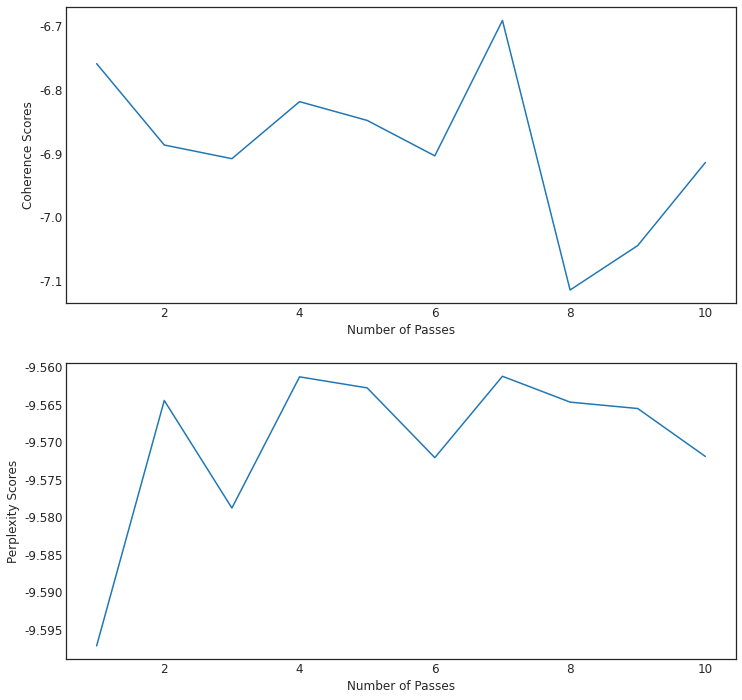

In [ ]:
x = list(range(1,11))

plt.subplot(2,1,1)
plt.plot(x, coherences_score)
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Scores')

plt.subplot(2,1,2)
plt.plot(x, perplexities_score)
plt.xlabel('Number of Passes')
plt.ylabel('Perplexity Scores')
plt.show();

### Topic 수 변화

In [ ]:
min_topics, max_topics = 10, 40
coherences_score2=[]
perplexities_score2=[] 

for num_topics in range(min_topics, max_topics) :
  time_before = time.time()
  lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1)
  print('num_topics "{}"'.format(num_topics))
 
  cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary)

  coherences_score2.append(cm.get_coherence())
  perplexities_score2.append(lda_model.log_perplexity(corpus))

  print("Cpherence : ", cm.get_coherence())    
  print('Perplexity : ', lda_model.log_perplexity(corpus))
  print('Time : ', (time.time() - time_before)/60)
  print('='*30)

num_topics "10"
Cpherence :  0.29959201485854475
Perplexity :  -9.509898445804918
Time :  8.192885875701904
num_topics "11"
Cpherence :  0.30844295858688237
Perplexity :  -9.554705642678995
Time :  8.187739483515422
num_topics "12"
Cpherence :  0.3102310248556667
Perplexity :  -9.579605709376077
Time :  8.099895668029784
num_topics "13"
Cpherence :  0.3014273447336653
Perplexity :  -9.629686464546198
Time :  8.36660596927007
num_topics "14"
Cpherence :  0.2966000717485561
Perplexity :  -9.663380880219048
Time :  8.485076022148132
num_topics "15"
Cpherence :  0.27741544269692453
Perplexity :  -9.70357384480485
Time :  8.381553256511689
num_topics "16"
Cpherence :  0.2870596381887557
Perplexity :  -9.735850238110563
Time :  8.433014372984568
num_topics "17"
Cpherence :  0.3031926908275957
Perplexity :  -9.742410144750172
Time :  8.756218608220419
num_topics "18"
Cpherence :  0.282323078695876
Perplexity :  -9.787875585322489
Time :  8.70800741116206
num_topics "19"
Cpherence :  0.2895293

In [ ]:
coherences_score2

[0.29959201485854475,
 0.30844295858688237,
 0.3102310248556667,
 0.3014273447336653,
 0.2966000717485561,
 0.27741544269692453,
 0.2870596381887557,
 0.3031926908275957,
 0.282323078695876,
 0.28952932184609315,
 0.3034700046623134,
 0.2999880691827933,
 0.31456289586436614,
 0.28616205562865504,
 0.31084273479529806,
 0.3149342188669043,
 0.32090632568178107,
 0.30968654970657417,
 0.3032716901435903,
 0.3051744573749708,
 0.3201625332372456,
 0.32837080612164465,
 0.33106687642552246,
 0.30784406698943184,
 0.3325022994725546,
 0.32246013761898173,
 0.32985523404118977,
 0.33761151784651827,
 0.33956193110283117,
 0.3541408169451799]

In [ ]:
perplexities_score2

[-9.509894551900654,
 -9.554705127045043,
 -9.579600694243855,
 -9.629685659383027,
 -9.663378216376149,
 -9.70357257125749,
 -9.73584714232243,
 -9.742412295483373,
 -9.787862335198176,
 -9.805900179014149,
 -9.839683644848744,
 -9.853779621692988,
 -9.890065288924445,
 -9.912276138889487,
 -9.947306086106277,
 -9.958123581712204,
 -9.983211159446357,
 -10.00908949900341,
 -10.023181097950152,
 -10.04671147932976,
 -10.064031144095521,
 -10.098132104079292,
 -10.11222613293533,
 -10.124310560306235,
 -10.151228344872642,
 -10.165354187225338,
 -10.169427989683928,
 -10.18998897101204,
 -10.226634089358013,
 -10.223845162256174]

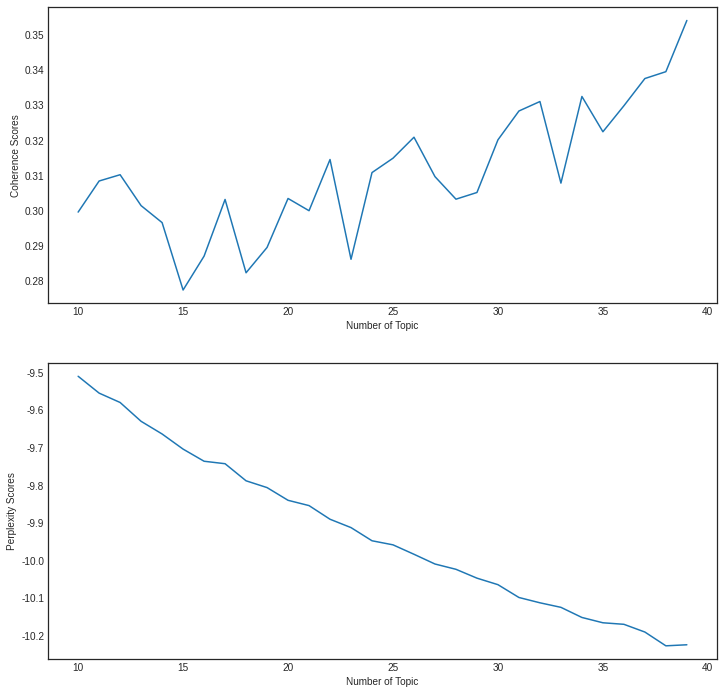

In [ ]:
x = [int(i) for i in range(min_topics, max_topics)]
# x = [int(i) for i in range(10, 40)]

plt.subplot(2,1,1)
plt.plot(x, coherences_score2)
plt.xlabel('Number of Topic')
plt.ylabel('Coherence Scores')

plt.subplot(2,1,2)
plt.plot(x, perplexities_score2)
plt.xlabel('Number of Topic')
plt.ylabel('Perplexity Scores')
plt.show();

In [ ]:
# # 모델 저장
# # Save model to disk.
# temp_file = datapath("lda_model.gensim")
# lda_model.save(temp_file)

# # Load a potentially pretrained model from disk.
# # lda_model = LdaModel.load(temp_file)

## LDA 시각화

In [ ]:
lda_model_12 = LdaModel(corpus, num_topics=12, id2word=dictionary, passes=1)
lda_model_22 = LdaModel(corpus, num_topics=22, id2word=dictionary, passes=1)
lda_model_26 = LdaModel(corpus, num_topics=26, id2word=dictionary, passes=1)
lda_model_34 = LdaModel(corpus, num_topics=34, id2word=dictionary, passes=1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis_12 = pyLDAvis.gensim.prepare(lda_model_12, corpus, dictionary)
pyLDAvis.display(vis_12)

In [ ]:
pyLDAvis.enable_notebook()
vis_22 = pyLDAvis.gensim.prepare(lda_model_22, corpus, dictionary)
pyLDAvis.display(vis_22)

In [ ]:
pyLDAvis.enable_notebook()
vis_26 = pyLDAvis.gensim.prepare(lda_model_26, corpus, dictionary)
pyLDAvis.display(vis_26)

In [ ]:
pyLDAvis.enable_notebook()
vis_34 = pyLDAvis.gensim.prepare(lda_model_34, corpus, dictionary)
pyLDAvis.display(vis_34)

# 시계열 분석

In [ ]:
data_time = data_tot[['일자', 'noun']]

# noun 컬럼 astype (object -> string)
data_time['noun'] = data_time['noun'].astype('string')

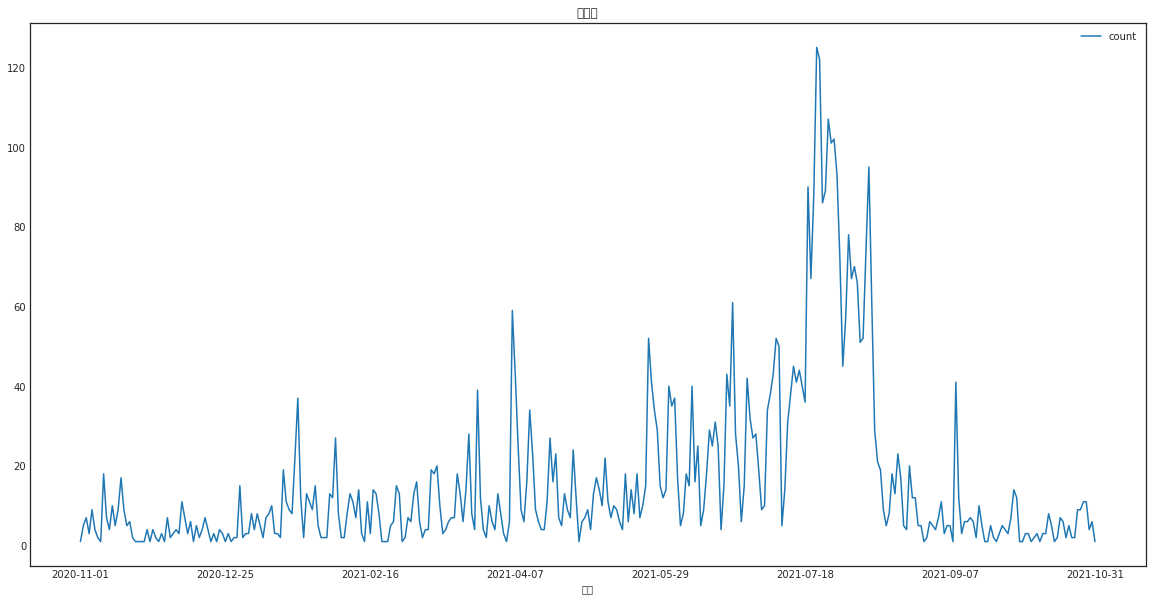

In [ ]:
from wordcloud.wordcloud import FONT_PATH
# 특정 keyword 검색 시 dataframe 추출
keyword = '올림픽'
data = data_time[data_time['noun'].str.contains(keyword)]

# 제목에 미세먼지가 들어간 경우 -> count = 1
data['count']=1
data = data[['일자', 'count']]

# 일별로 키워드 추이 나타내기
data = data.groupby('일자').sum()

fig, ax = plt.subplots(figsize=(20,10))
data.plot(ax=ax)
plt.title(keyword)
plt.show()

In [ ]:
decompostion = sm.tsa.seasonal_decompose(data['count'], model='additive', freq=12)
fig = decompostion.plot()
fig.set_size_inches(20,10)
plt.show()

TypeError: ignored

In [ ]:
# train / test 데이터 스플릿 8:2
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [ ]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=50, ax=ax[1]); # modify not to generate graph twice

In [ ]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['count'].diff() # default = 1
diff_train_data = diff_train_data.dropna() # 결측치 제거 (마지막값)
print('####### Raw Data #######')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

In [ ]:
# Difference data plot

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(train_data['count'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

In [ ]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle('Difference Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=50, ax=ax[1]); 

## SARIMA 모델 
- AIC 스코어가 너무 낮음
- P-VALUE가 다 0인게 이상함
- PREDICTION 값이 -가 나오면 안되는데

In [ ]:
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1, 
                             max_p = 5, max_q = 5, m=12, seasonal=True,
                             d=1, D=1, max_P=3, max_Q = 3,
                             trace=True,
                             error_action = 'ignore',
                             suppress_warnings = True,
                             stepwise=False)

In [ ]:
auto_arima_model.summary()

In [ ]:
# predict를 쓴다.
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
print(prediction)

In [ ]:
prediction_value = prediction[0]
prediction_lb = prediction[1][:,0]
prediction_ub = prediction[1][:,1]
prediction_index = list(test_data.index)
r2 = r2_score(test_data, prediction_value)
prediction_index[0]

In [ ]:
fig, ax = plt.subplots(figsize= (20,10))
ax.plot(data.index, data)
ax.vlines(prediction_index[0], -200, 150, linestyle='--', color='r', label='Start of Forecast')
ax.plot(prediction_index, prediction_value, label='Prediction')
ax.fill_between(prediction_index, prediction_ub, prediction_lb, color='k', alpha=1, label='interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA({auto_arima_model.order, auto_arima_model.seasonal_order}) prediction results: {round(r2,2)}(r2 score)' )